# Separation property of penultimate layer in deep neural networks for classification

For a long time I've known that that deeper layers of NNs are great feature extractors and that their activations can serve as embeddings.
However, just recently I've realized that due to the linearity of the last layer, the penultimate layer must pretty much make data linearly separable.
Of course, the last layer might have a non-linear activation function, but take sigmoid for example. In its core the neuron is still only a linear transformation that is squashed by the sigmoid function.
Similar reasoning can be applied to other activation functions.
This allows us to see a neural network as a series of transformations that attempt to make the data linearly separable.

In this notebook I will try to demonstrate this idea.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision

import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class FilteredMNIST(torchvision.datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data, self.targets = self.data[(self.targets == 0) | (self.targets == 1)], self.targets[(self.targets == 0) | (self.targets == 1)]

trainset_filtered = FilteredMNIST(root='./data', train=True, download=True, transform=transform)
testset_filtered = FilteredMNIST(root='./data', train=False, download=True, transform=transform)

trainloader_filtered = torch.utils.data.DataLoader(trainset_filtered, batch_size=64, shuffle=True)
testloader_filtered = torch.utils.data.DataLoader(testset_filtered, batch_size=64, shuffle=False)

In [55]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 2)
        self.fc3 = nn.Linear(2, 1)

    def up_to_penultimate(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return F.tanh(self.fc2(x)) # let's scale it to [-1, 1]
        
    def forward(self, x):
        x = self.up_to_penultimate(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = MNISTConvNet()
print(model)

MNISTConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)


In [80]:
def train_model(model, trainloader, testloader, criterion, num_epochs=10, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(criterion, nn.CrossEntropyLoss):
                loss = criterion(outputs, labels)
            else:
                labels = labels.float().view(-1, 1)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(trainloader)
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                if isinstance(criterion, nn.CrossEntropyLoss):
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                else:
                    labels = labels.float().view(-1, 1)
                    loss = criterion(outputs, labels)
                    predicted = (outputs > 0.5).float()
                test_loss += loss.item()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_loss /= len(testloader)
        accuracy = 100 * correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')



In [ ]:
criterion = nn.BCELoss()
train_model(model, trainloader_filtered, testloader_filtered, criterion, num_epochs=3)

It seems that solving binary MNIST is super primitive. Let's see whether the outputs of the last layer look as we expect.

/tmp/ipykernel_80841/2551334433.py:27: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 2115
  plt.legend( handles=scatter.legend_elements()[0], labels=[str(i.item()) for i in set(all_labels)] )


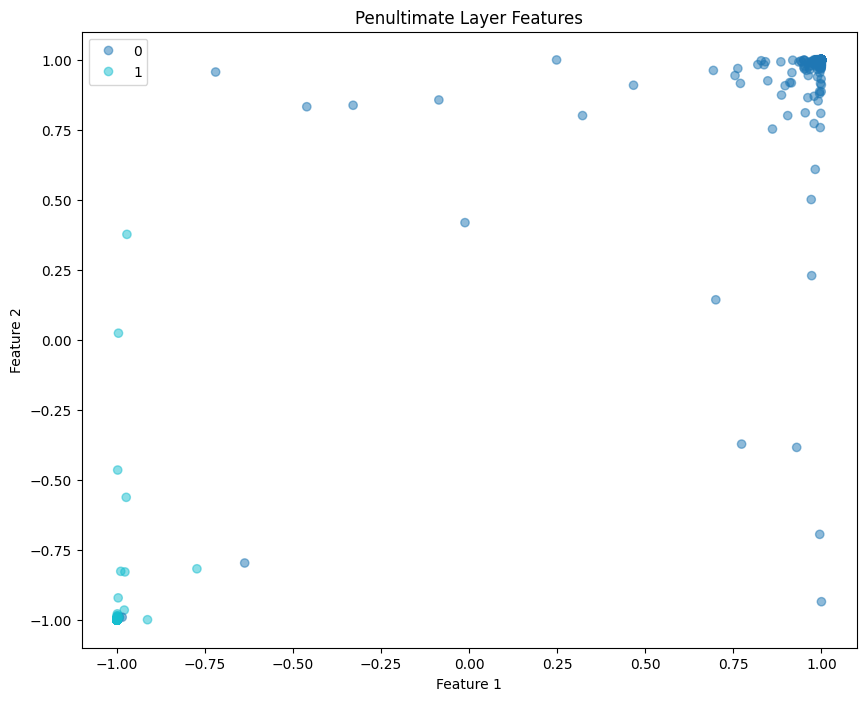

In [83]:
import matplotlib.pyplot as plt

def plot_test_data(model, testloader):
    def is_weird(x, y):
        return -0.8 <= x <= 0.8 or -0.8 <= y <= 0.8
    
    model.eval()
    all_features = []
    all_labels = []

    weird_inputs = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            features = model.up_to_penultimate(inputs)
            all_features.append(features)
            for i, ftr in enumerate(features):
                if is_weird(ftr[0], ftr[1]):
                    weird_inputs.append((inputs[i], labels[i]))
            all_labels.append(labels)
    
    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_features[:, 0], all_features[:, 1], c=all_labels, cmap='tab10', alpha=0.5)
    plt.legend( handles=scatter.legend_elements()[0], labels=[str(i.item()) for i in set(all_labels)] )
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Penultimate Layer Features')
    plt.show()

    return weird_inputs

weird_inputs = plot_test_data(model, testloader_filtered)

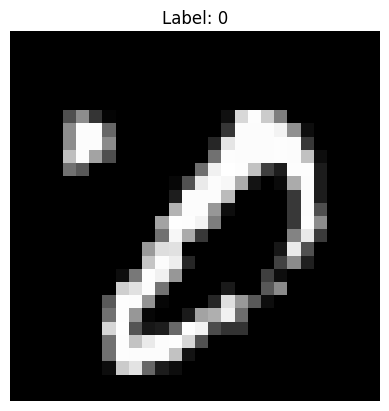

In [45]:
def plot_mnist_image(image, label):
    image = image.squeeze().numpy()  # Remove batch dimension and convert to numpy array
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label.item()}')
    plt.axis('off')
    plt.show()

for image, label in weird_inputs:
    plot_mnist_image(image, label)


The point that is not clearly separated looks quite messy.

Now let's look how does the penultimate layer looks in a general mnist.

In [87]:
class MNISTConvNet(nn.Module):
    def __init__(self, penultimate_dim=2):
        super(MNISTConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, penultimate_dim)
        self.fc3 = nn.Linear(penultimate_dim, 10)

    def up_to_penultimate(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return F.tanh(self.fc2(x)) # let's scale it to [-1, 1]
        
    def forward(self, x):
        x = self.up_to_penultimate(x)
        x = self.fc3(x)
        return x

model = MNISTConvNet()
print(model)

MNISTConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=10, bias=True)
)


In [82]:
cross_entropy = nn.CrossEntropyLoss()
train_model(model, trainloader, testloader, num_epochs=3, criterion=cross_entropy)

Epoch 1/3, Train Loss: 1.5719, Test Loss: 1.3294, Test Accuracy: 38.46%
Epoch 2/3, Train Loss: 1.2489, Test Loss: 1.1923, Test Accuracy: 41.11%
Epoch 3/3, Train Loss: 1.1564, Test Loss: 1.1419, Test Accuracy: 40.84%


/tmp/ipykernel_80841/2551334433.py:27: UserWarning: Mismatched number of handles and labels: len(handles) = 10 len(labels) = 10000
  plt.legend( handles=scatter.legend_elements()[0], labels=[str(i.item()) for i in set(all_labels)] )


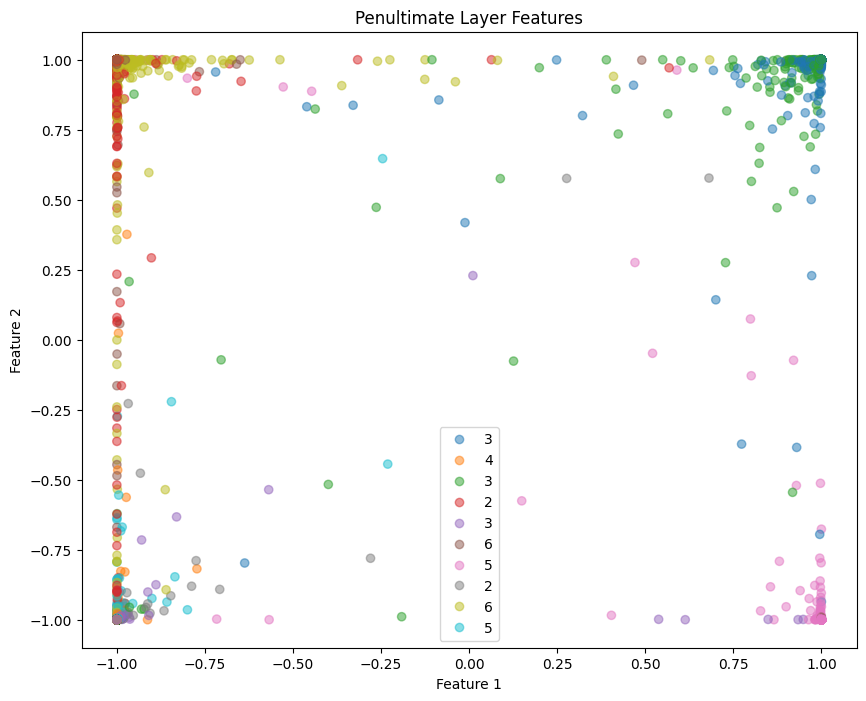

In [84]:
weird_inputs = plot_test_data(model, testloader)

The model has problems achieving more than 40% accuracy. 
An interesting hypothesis that comes to my mind based on the above plot is that in 2 dimensions we cannot separate more than 4 classes linearly.

A cube has 8 corners, so let's see whether we can achieve 80 %.

In [88]:
model = MNISTConvNet(penultimate_dim=3)
train_model(model, trainloader, testloader, num_epochs=5, criterion=cross_entropy)

Epoch 1/5, Train Loss: 1.2078, Test Loss: 0.8153, Test Accuracy: 76.46%
Epoch 2/5, Train Loss: 0.6338, Test Loss: 0.5465, Test Accuracy: 77.93%
Epoch 3/5, Train Loss: 0.4667, Test Loss: 0.4357, Test Accuracy: 78.78%
Epoch 4/5, Train Loss: 0.3983, Test Loss: 0.3890, Test Accuracy: 78.84%
Epoch 5/5, Train Loss: 0.3607, Test Loss: 0.3631, Test Accuracy: 79.06%


Based on our hypothesis 4 dimensions should be enough to separate the MNIST.

In [89]:
model = MNISTConvNet(penultimate_dim=4)
train_model(model, trainloader, testloader, num_epochs=5, criterion=cross_entropy)

Epoch 1/5, Train Loss: 1.0587, Test Loss: 0.5686, Test Accuracy: 87.96%
Epoch 2/5, Train Loss: 0.4349, Test Loss: 0.3443, Test Accuracy: 88.54%
Epoch 3/5, Train Loss: 0.2897, Test Loss: 0.2610, Test Accuracy: 89.63%
Epoch 4/5, Train Loss: 0.2086, Test Loss: 0.1510, Test Accuracy: 98.59%
Epoch 5/5, Train Loss: 0.0986, Test Loss: 0.0933, Test Accuracy: 98.75%
